## ChatGPT Labelling

#### Glossary

1. ChatGPT API Connection
2. Verification of the labelling on text already labelled by us
3. Labelling by ChatGPT

In [101]:
#!pip install openai
#!pip install langchain
#!pip install python-Levenshtein
#!pip install fuzzywuzzy
#!pip install sentence_transformers

In [102]:
import re
import ast
import pickle
import Levenshtein
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from ecbdata import ecbdata
from fuzzywuzzy import fuzz
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

from openai import OpenAI
from jinja2 import Template

tqdm.pandas()

#ECB Color
color = (17/255, 49/255, 147/255)

# File containing the functions
from src.Metaphor_Labelling_Functions import *

In [103]:
# OpenAI Api Key: 
api_key = open("C:\\Users\\School\\Desktop\\GPT_KEY.txt", "r").read()

# Target words:
words_to_match = ["inflation","deflation","inflationary","desinflationary","hyperinflation","disinflation"]

In [104]:
# Import dataset containing the interveiw data
df = pd.read_csv('Data/Final_Data.csv')

In [105]:
df.head()

,Unnamed: 0,Date,Media,Member,Link,Information,Questions,Answers,Metaphors,Metaphors Sentence,...,pos_metaphors_len,Sentences,Frequency,Sentences_len,Sentence_GPT_Majority,GPT_Majority_Category,Matched_Metaphors,pos_relationships,pos_sentences,pos_relationships_len
0,0,2005-12-23,Interview with Der Spiegel,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,"SPIEGEL: Monsieur Trichet, any concrete uttera...",The publication of the translation was authori...,NaN,NaN,...,0,['We will in the future take the decisions tha...,5,3,['we will in the future take the decisions tha...,"['machine', 'disease', 'plant']","[True, True, True]","[('inflationary', 'expectation'), ('inflation'...",[],3
1,1,2005-12-19,Interview with Hospodářské Noviny,Otmar Issing,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,The new EU member states want to adopt the eur...,These questions are all closely related to eac...,NaN,NaN,...,0,['We are not confronted with deflation but wit...,1,1,['we are not confronted with deflation but wit...,['warfare'],[True],[],[],0
2,2,2005-12-19,Interview with Financial Times and Financial T...,Lucas Papademos,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,"Mr Papademos, you have responsibility as ECB V...",A comparison of the risks involved when short-...,NaN,NaN,...,2,['If longterm interest rates remain at a low l...,18,11,['in the us the policy stance changed and the ...,"['fire', 'fire', 'fire', 'fire']","[True, True, True, True]","[('future', 'inflation'), ('low', 'inflation')...",['it a higher level of interest rates could fo...,8
3,3,2005-12-15,Interview with Paris Match,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,Paris Match. After two uneventful years at the...,The publication of the translation was authori...,NaN,NaN,...,0,['You are exaggerating the increase in the cos...,7,5,['furthermore we must not wait until inflation...,"['warfare', 'disease', 'disease', 'machine', '...","[True, True, True, True, True]","[('inflationary', 'remain'), ('inflationary', ...",[],2
4,4,2005-12-09,Interview in Il Giornale,Lorenzo Bini Smaghi,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,"However, Europe’s politicians, with few except...","By Angelo Allegri, our correspondent in Frankf...",NaN,NaN,...,0,['The rise has helped to keep inflation expect...,7,7,['the rise has helped to keep inflation expect...,"['orientation', 'orientation', 'orientation', ...","[True, True, True, True, True, True, True]","[('inflation', 'regard')]",[],1


In [106]:
df.iloc[62]

Unnamed: 0                                                               62
Date                                                             2010-05-21
Media                     Interview with Frankfurter Allgemeine Zeitung ...
Member                                                  Jean-Claude Trichet
Link                      https://www.ecb.europa.eu/press/inter/date/201...
Information                                           Information not found
Questions                 FAZ:[end_question] Trichet:[end_question] FAZ:...
Answers                   Trichet: We are constantly urging the banks to...
Metaphors                                                               NaN
Metaphors Sentence                                                      NaN
YoB                                                                    1942
Gender                                                                    M
Country                                                              France
Period on th

# Pre-processing

Prepare the data for the labeling

In [107]:
def preprocess_text(df,words_to_match):
        text_preproc = (
                df.Answers
                .astype(str)
                .progress_apply(lambda row: remove_end_answer(row))
                .progress_apply(lambda row: remove_special_characters_keep_point(row))
                .progress_apply(lambda row: remove_unnecessary_spaces(row))
                .progress_apply(lambda row: remove_starting_month(row))
                .progress_apply(lambda row: extract_sentences(row,words_to_match)))

        df["Sentences"]=text_preproc

        return df

df = preprocess_text(df, words_to_match=words_to_match)

100%|██████████| 519/519 [00:00<00:00, 1634.85it/s]


In [108]:
df["Frequency"] = df["Answers"].apply(count_frequency, words_to_match=words_to_match)
df['Sentences_len'] = df['Sentences'].apply(len)

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


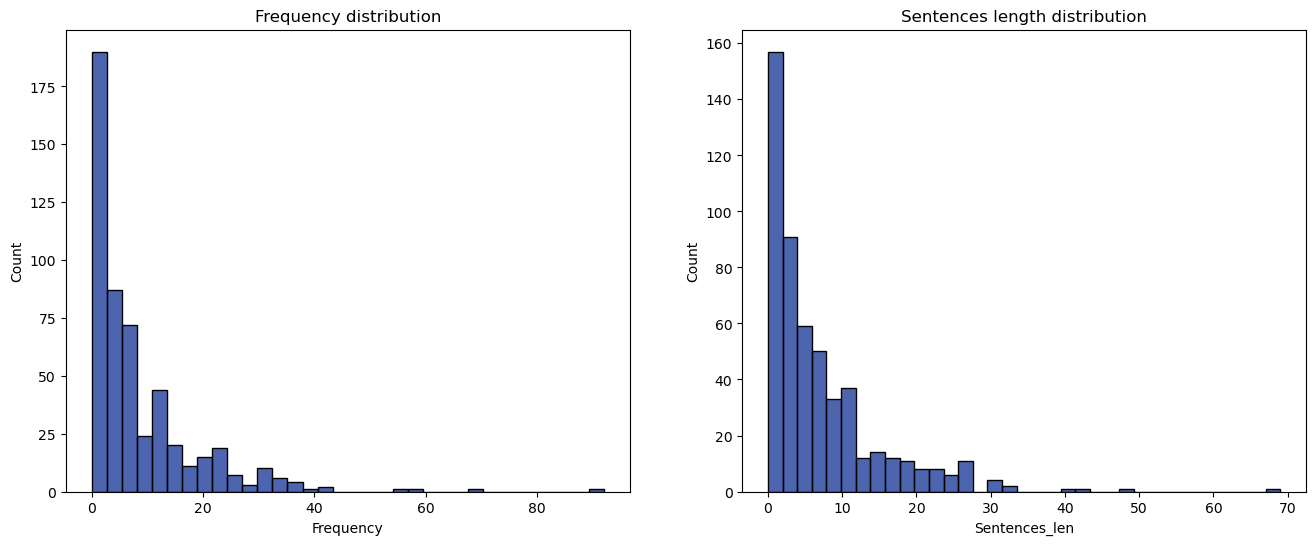

In [109]:
# Plot the distribution of Frequency and Sentences_len
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(df["Frequency"], ax=ax[0], color=color)
ax[0].set_title("Frequency distribution")
sns.histplot(df["Sentences_len"], ax=ax[1], color=color)
ax[1].set_title("Sentences length distribution")
plt.show()

# Labeled Data

We will use the human labeled data to verify the perfromance of Chat GPT 4o to extract, identify and classify conceptual metaphors. 

If the perfromance of Chat GPT is considered as equal to human perfromance, then we will use GPT to label the entire dataset.

In [110]:
"""# Dataframe with the labeled Metaphors
df_labels = df[df['Metaphors'].notnull()].copy()
print("Shape of the dataset with labeled Metaphors: ", df_labels.shape)"""

df_labels = pd.read_csv('Data/Labeled_Data.csv')
print("Shape of the labeled data:", df_labels.shape)

Shape of the labeled data: (68, 56)


In [111]:
# This cell could be unnecessay in later versions (or only run ones!)

# lambda function to convert string representations of lists into actual lists
parse_list = lambda x: ast.literal_eval(x) if x != '[\'None\']' else []
df_labels.loc[:, 'Metaphors Sentence'] = df_labels['Metaphors Sentence'].apply(parse_list)
df_labels.loc[:, 'Sentences'] = df_labels['Sentences'].apply(parse_list)
df_labels.loc[:, 'Category_Labeled'] = df_labels['Category_Labeled'].apply(parse_list)

# lambda function to count the elements in each list
df_labels.loc[:, 'Metaphors_len'] = df_labels['Metaphors Sentence'].apply(len)
df_labels.loc[:, 'Sentences_len'] = df_labels['Sentences'].apply(len)
df_labels.loc[:, 'Category_len'] = df_labels['Category_Labeled'].apply(len)

In [112]:
# Print total number of Metaphors
print("Total number of Metaphors (Label): ", df_labels['Metaphors_len'].sum())
print("Total number of Sentences (with words_to_match): ", df_labels['Sentences'].apply(len).sum())
print("Average number of Metaphors per Interview: ", df_labels['Metaphors_len'].mean())
print("Ratio of Metaphors to Sentences: ", df_labels['Metaphors_len'].sum() / df_labels['Sentences'].apply(len).sum())

Total number of Metaphors (Label):  493
Total number of Sentences (with words_to_match):  577
Average number of Metaphors per Interview:  7.25
Ratio of Metaphors to Sentences:  0.854419410745234


In [113]:
# Some of the labeled Metaphors have the Starting date of the interview, we need to remove it as it was removed from the Sentences
df_labels['Metaphors Sentence'] = df_labels['Metaphors Sentence'].apply(lambda x: [remove_starting_month(sentence) for sentence in x])

# Some of the labeled Metaphors have a "low;" in the string resulting from an error, we need to remove it as it not present in the Sentences
df_labels['Metaphors Sentence'] = df_labels['Metaphors Sentence'].apply(lambda x: [sentence.replace("low;", " ") for sentence in x])

In [114]:
# Sanity check: Match 'Metaphors Sentence' with 'Sentences' to see if they are present
df_temp = add_match_column(df_labels.copy(), threshold=0.5)

# Compare the 'Matched_Labeled_len' with 'Metaphors_len' to see if all the Metaphors are matched
df_temp['Matched_Labeled_len'].sum(), df_temp['Metaphors_len'].sum()

(475, 493)

Some of the labeled sentences do not match with the 'Sentences' extracted from the interviews. The Fuzzy threshold had to be set to 0.5 to match the most possible Metaphors. This might be due to Human error while labeling or the preprocessing step removing special characters such as "-" that might change the meaning of a word.

### 1. ChatGPT API Connection


In [115]:
initial_prompt = open("GPT_Prompts/Prompt_1.txt", "r").read()

following_prompts = """Detect and extract the conceptual metaphors related to inflation, deflation, inflationary, disinflationary, hyperinflation, and disinflation in the following sentences:
{{list_sentences}}

Return the metaphors in the format:
Sentence: [Sentence text] Category: [Category]

Where, Category is one of the following:
Fire, Liquids, Plant, Animal, Disease, Warfare, Sports, Machine, Orientation, Other

The output has to be in the right format. The categories are predefined and you have to choose the right category based on the metaphor used in the sentence.
"""

following_prompts = Template(following_prompts)

In [116]:
df_labels["Sentences"].iloc[3]

['On the other hand in July there were upside risks to inflation but now they are balanced.',
 'This is a major asset for Europe it protects us from the materialisation of the risk of inflation as well as the materialisation of the risk of deflation.']

In [117]:
print(following_prompts.render(list_sentences=df["Sentences"].iloc[2]))

# Limit size of df to 10
#df_labels = df_labels.iloc[:10]

sentences_list = []

for index, row in df.iterrows():
    sentences = row["Sentences"]
    if len(sentences) > 0:
        sentences_list.append(sentences)

print(len(sentences_list))

Detect and extract the conceptual metaphors related to inflation, deflation, inflationary, disinflationary, hyperinflation, and disinflation in the following sentences:
['If longterm interest rates remain at a low level as a result of favourable inflation expectations influenced by a credible monetary policy oriented towards price stability and as a consequence of the impact of other factors then the effect on economic activity of a rise in shortterm interest rates is going to be more muted.', 'Public perceptions and expectations of future inflation should be favourably influenced by a change in the monetary policy stance that aims at preserving price stability.', 'It a higher level of interest rates could foster expectations of lower inflation and higher real disposable incomes and increase confidence particularly in countries where public perceptions of current inflation are less favourable than actual inflation and financial markets inflation expectations.', 'It was necessary in ord

In [118]:
all_prompts = [initial_prompt] + [following_prompts.render(list_sentences=sentences) for sentences in sentences_list]
all_prompts[:3]

['Title: Conceptual Metaphor Detection\n\nDescription: Detect and extract conceptual Metaphors in a set of sentences.\n\nTask: Given a set of sentences, you are required to identify and extract conceptual metaphors present.  \nOnly consider conceptual metaphors related to inflation, deflation, inflationary, disinflationary, hyperinflation, and disinflation.\nAfter identifying the metaphors, return the sentences that contain the metaphors and label it in the format:\n\nSentence: [Sentence text] Category: [Category]\n\nWhere, Category is one of the following 10 options (with a set of examples):\nFire = [\'ignite\', \'fuel\', \'spark\', \'dampen\', \'stoke\', \'kindle\', \'choke\', \'stifle\', \'fan\', \'flare-up\', \'douse\', \'snuff\']\nLiquids = [\'erode\', \'surge\', \'subside\', \'simmers\', \'emergence\', \'ebb\', \'dilute\', \'spurt\', \'recede\', \'buoy\']\nPlant = [\'hedge\', \'nip\']\nAnimal = [\'soar\', \'rampant\', \'curb\', \'tame\', \'rein\', \'creep\', \'whip\', \'gallop\',

In [119]:
all_prompts = [[{"role": "system", "content": prompt}] for prompt in all_prompts]
#all_prompts

In [120]:
"""client = OpenAI(api_key=api_key)

# model: "gpt-3.5-turbo", "gpt-4o"
# temperature: Controls the creativity of the responses. Lower values make the output more focused and deterministic, while higher values make it more random
# We want GPT to be more deterministic and focused, and return the metaphors in the right format - Default value: 0
gpt_answer = [client.chat.completions.create(messages=msg, model='gpt-4o', temperature=0).choices[0].message.content for msg in all_prompts]"""

'client = OpenAI(api_key=api_key)\n\n# model: "gpt-3.5-turbo", "gpt-4o"\n# temperature: Controls the creativity of the responses. Lower values make the output more focused and deterministic, while higher values make it more random\n# We want GPT to be more deterministic and focused, and return the metaphors in the right format - Default value: 0\ngpt_answer = [client.chat.completions.create(messages=msg, model=\'gpt-4o\', temperature=0).choices[0].message.content for msg in all_prompts]'

In [121]:
"""gpt_answer
print(len(gpt_answer))"""

'gpt_answer\nprint(len(gpt_answer))'

In [122]:
"""# Save the GPT-4 output to a pickle file
with open('gpt_answer_all_3.pkl', 'wb') as f:
    pickle.dump(gpt_answer, f)"""

"# Save the GPT-4 output to a pickle file\nwith open('gpt_answer_all_3.pkl', 'wb') as f:\n    pickle.dump(gpt_answer, f)"

### Investigate the 3 different outputs:

As 3 different prompts were tested and saved, now we will analyse the outputs and keep the metaphors appearing at least twice in a final 'robust' dataset.

In [123]:
# Load the GPT-4 output from the pickle file
with open('GPT_Output/gpt_answer_1.pkl', 'rb') as f:
    gpt_answer_1 = pickle.load(f)

with open('GPT_Output/gpt_answer_2.pkl', 'rb') as f:
    gpt_answer_2 = pickle.load(f)

with open('GPT_Output/gpt_answer_3.pkl', 'rb') as f:
    gpt_answer_3 = pickle.load(f)

# Drop the first element which is the initial prompt
gpt_answer_1 = gpt_answer_1[1:]
gpt_answer_2 = gpt_answer_2[1:]
gpt_answer_3 = gpt_answer_3[1:]

gpt_names = ["GPT_1", "GPT_2", "GPT_3", "GPT_Majority"]

print("The length of the GPT-4 output for the first prompt: ", len(gpt_answer_1))
print("The length of the GPT-4 output for the second prompt: ", len(gpt_answer_2))
print("The length of the GPT-4 output for the third prompt: ", len(gpt_answer_3))

The length of the GPT-4 output for the first prompt:  58
The length of the GPT-4 output for the second prompt:  58
The length of the GPT-4 output for the third prompt:  58


In [124]:
print("Shape of the dataset before adding GPT-4 output: ", df_labels.shape)

# Drop the rows where the Sentences are empty
#df_labels = df_labels[df_labels['Sentences'].apply(len) > 0]

print("Shape of the dataset after dropping empty Sentences: ", df_labels.shape)

for gpt_name, gpt_answer in zip(gpt_names, [gpt_answer_1, gpt_answer_2, gpt_answer_3]):
    df_labels = add_columns_to_dataframe(df_labels, gpt_answer, name=gpt_name)

print("Shape of the dataset after adding GPT-4 output: ", df_labels.shape)

Shape of the dataset before adding GPT-4 output:  (68, 56)
Shape of the dataset after dropping empty Sentences:  (68, 56)
Shape of the dataset after adding GPT-4 output:  (68, 56)


In [125]:
# Sanity check:
print("Total number of Metaphors labeled: ", df_labels['Metaphors_len'].sum())
print("Total number of Sentences (with words_to_match): ", df_labels['Sentences'].apply(len).sum())
print("")
print("Total number of sentences in the 'Sentence_GPT_1' column: ", df_labels['Sentence_GPT_1'].apply(len).sum())
print("Total number of sentences in the 'Sentence_GPT_2' column: ", df_labels['Sentence_GPT_2'].apply(len).sum())
print("Total number of sentences in the 'Sentence_GPT_3' column: ", df_labels['Sentence_GPT_3'].apply(len).sum())
print("")
print("Ratio of GPT (Prompt 1) Metaphors to Sentences: ", df_labels['Sentence_GPT_1'].apply(len).sum() / df_labels['Sentences'].apply(len).sum())
print("Ratio of GPT (Prompt 2) Metaphors to Sentences: ", df_labels['Sentence_GPT_2'].apply(len).sum() / df_labels['Sentences'].apply(len).sum())
print("Ratio of GPT (Prompt 3) Metaphors to Sentences: ", df_labels['Sentence_GPT_3'].apply(len).sum() / df_labels['Sentences'].apply(len).sum())

Total number of Metaphors labeled:  493
Total number of Sentences (with words_to_match):  577

Total number of sentences in the 'Sentence_GPT_1' column:  497
Total number of sentences in the 'Sentence_GPT_2' column:  497
Total number of sentences in the 'Sentence_GPT_3' column:  505

Ratio of GPT (Prompt 1) Metaphors to Sentences:  0.8613518197573656
Ratio of GPT (Prompt 2) Metaphors to Sentences:  0.8613518197573656
Ratio of GPT (Prompt 3) Metaphors to Sentences:  0.8752166377816292


### Majority voting:

Keep only the Metaphors that appear in at least two of the 3 outputs given by 3 different prompts.

In [126]:
df_labels = majority_voting_with_category(df_labels)
print("Ratio of GPT (Majority Vote) Metaphors to Sentences: ", df_labels['Sentence_GPT_Majority'].apply(len).sum() / df_labels['Sentences'].apply(len).sum())

Ratio of GPT (Majority Vote) Metaphors to Sentences:  0.8769497400346621


The ratio of metaphor per sentence containing the word 'inflation' went up after majority voting, hence resulting in more robust results for the rest of the analysis.

### Preprocessing the labeled sentences and GPT answers to perform analysis:

In [127]:
for gpt_name in gpt_names:
    df_labels = add_comparison_column(df_labels, threshold=30, name=gpt_name)

## Metaphor matching using Levenstein distance:

In [128]:
for gpt_name in gpt_names:
    print(f"Total number of Metaphors (prompt {gpt_name}): ", df_labels[f'Sentence_{gpt_name}'].apply(len).sum())
    print(f"Total number of True values for (prompt {gpt_name}): ", df_labels[f'Comparison_Result_{gpt_name}'].apply(sum).sum())
    print(f"Ratio of Metaphors correctly identified (vs labeled data) (prompt {gpt_name}): ", df_labels[f'Comparison_Result_{gpt_name}'].apply(sum).sum() / df_labels[f'Comparison_Result_{gpt_name}'].apply(len).sum())
    print(f"Ratio of Categories correctly identified (vs labeled data) (prompt {gpt_name}): ", df_labels[f'Category_Result_{gpt_name}'].apply(sum).sum() / df_labels[f'Category_Result_{gpt_name}'].apply(len).sum())
    print("")

Total number of Metaphors (prompt GPT_1):  497
Total number of True values for (prompt GPT_1):  383
Ratio of Metaphors correctly identified (vs labeled data) (prompt GPT_1):  0.7706237424547284
Ratio of Categories correctly identified (vs labeled data) (prompt GPT_1):  0.8048289738430584

Total number of Metaphors (prompt GPT_2):  497
Total number of True values for (prompt GPT_2):  389
Ratio of Metaphors correctly identified (vs labeled data) (prompt GPT_2):  0.7826961770623743
Ratio of Categories correctly identified (vs labeled data) (prompt GPT_2):  0.7806841046277666

Total number of Metaphors (prompt GPT_3):  505
Total number of True values for (prompt GPT_3):  386
Ratio of Metaphors correctly identified (vs labeled data) (prompt GPT_3):  0.7643564356435644
Ratio of Categories correctly identified (vs labeled data) (prompt GPT_3):  0.7782178217821782

Total number of Metaphors (prompt GPT_Majority):  506
Total number of True values for (prompt GPT_Majority):  389
Ratio of Metapho

## Metrics Metaphors: 

In [129]:
sentences_list = extract_sentences_column(df_labels)
metaphors_list = extract_metaphors(df_labels)

# Get the true Y values (sentences matching with metaphors labeled)
df_true = metrics_dataframe(sentences_list, metaphors_list) 

In [130]:
for gpt_name in gpt_names:
    df_pred = metrics_dataframe(sentences_list, extract_metaphors(df_labels, name=gpt_name))
    calculate_metrics(df_labels, gpt_name, Fuzzy=False)
    get_confusion_matrix(df_true, df_pred, model_name=gpt_name)
    print("")

Accuracy (prompt GPT_1): 0.7706237424547284
Precision (prompt GPT_1): 0.7706237424547284
Recall (prompt GPT_1): 0.7768762677484787
F1 Score (prompt GPT_1): 0.7737373737373737

Confusion Matrix:
[[ 31  93]
 [ 52 401]]
True Positives (TP): 401
True Negatives (TN): 31
False Positives (FP): 93
False Negatives (FN): 52

Accuracy (prompt GPT_2): 0.7826961770623743
Precision (prompt GPT_2): 0.7826961770623743
Recall (prompt GPT_2): 0.7890466531440162
F1 Score (prompt GPT_2): 0.7858585858585859

Confusion Matrix:
[[ 34  90]
 [ 49 404]]
True Positives (TP): 404
True Negatives (TN): 34
False Positives (FP): 90
False Negatives (FN): 49

Accuracy (prompt GPT_3): 0.7643564356435644
Precision (prompt GPT_3): 0.7643564356435644
Recall (prompt GPT_3): 0.7829614604462475
F1 Score (prompt GPT_3): 0.7735470941883769

Confusion Matrix:
[[ 26  98]
 [ 49 404]]
True Positives (TP): 404
True Negatives (TN): 26
False Positives (FP): 98
False Negatives (FN): 49

Accuracy (prompt GPT_Majority): 0.768774703557312

## Metaphor matching using Fuzzy distance:

In [131]:
for gpt_name in gpt_names:
    df_labels = add_comparison_column_Fuzzy(df_labels, threshold=0.45, name=gpt_name)

In [132]:
for gpt_name in gpt_names:
        print(f"Total number of Metaphors (prompt {gpt_name}): ", df_labels[f'Sentence_{gpt_name}'].apply(len).sum())
        print(f"Total number of True values for (prompt {gpt_name}): ", df_labels[f'Matched_Metaphors_Fuzzy_{gpt_name}'].apply(sum).sum())
        print(f"Ratio of Metaphors correctly identified (vs labeled data) (prompt {gpt_name}): ", df_labels[f'Matched_Metaphors_Fuzzy_{gpt_name}'].apply(sum).sum() / df_labels[f'Matched_Metaphors_Fuzzy_{gpt_name}'].apply(len).sum())
        print(f"Ratio of Categories correctly identified (vs labeled data) (prompt {gpt_name}): ", df_labels[f'Matched_Categories_Fuzzy_{gpt_name}'].apply(sum).sum() / df_labels[f'Matched_Categories_Fuzzy_{gpt_name}'].apply(len).sum())
        print("")

Total number of Metaphors (prompt GPT_1):  497
Total number of True values for (prompt GPT_1):  451
Ratio of Metaphors correctly identified (vs labeled data) (prompt GPT_1):  0.9074446680080482
Ratio of Categories correctly identified (vs labeled data) (prompt GPT_1):  0.8048289738430584

Total number of Metaphors (prompt GPT_2):  497
Total number of True values for (prompt GPT_2):  453
Ratio of Metaphors correctly identified (vs labeled data) (prompt GPT_2):  0.9114688128772636
Ratio of Categories correctly identified (vs labeled data) (prompt GPT_2):  0.7806841046277666

Total number of Metaphors (prompt GPT_3):  505
Total number of True values for (prompt GPT_3):  460
Ratio of Metaphors correctly identified (vs labeled data) (prompt GPT_3):  0.9108910891089109
Ratio of Categories correctly identified (vs labeled data) (prompt GPT_3):  0.7782178217821782

Total number of Metaphors (prompt GPT_Majority):  506
Total number of True values for (prompt GPT_Majority):  461
Ratio of Metapho

In [133]:
for gpt_name in gpt_names:
    df_pred = metrics_dataframe(sentences_list, extract_metaphors(df_labels, name=gpt_name))
    calculate_metrics(df_labels, gpt_name, Fuzzy=True)
    get_confusion_matrix(df_true, df_pred, model_name=gpt_name)
    print("")

Accuracy (prompt GPT_1): 0.9074446680080482
Precision (prompt GPT_1): 0.9074446680080482
Recall (prompt GPT_1): 0.9148073022312373
F1 Score (prompt GPT_1): 0.9111111111111112

Confusion Matrix:
[[ 31  93]
 [ 52 401]]
True Positives (TP): 401
True Negatives (TN): 31
False Positives (FP): 93
False Negatives (FN): 52

Accuracy (prompt GPT_2): 0.9114688128772636
Precision (prompt GPT_2): 0.9114688128772636
Recall (prompt GPT_2): 0.9188640973630832
F1 Score (prompt GPT_2): 0.915151515151515

Confusion Matrix:
[[ 34  90]
 [ 49 404]]
True Positives (TP): 404
True Negatives (TN): 34
False Positives (FP): 90
False Negatives (FN): 49

Accuracy (prompt GPT_3): 0.9108910891089109
Precision (prompt GPT_3): 0.9108910891089109
Recall (prompt GPT_3): 0.9330628803245437
F1 Score (prompt GPT_3): 0.9218436873747495

Confusion Matrix:
[[ 26  98]
 [ 49 404]]
True Positives (TP): 404
True Negatives (TN): 26
False Positives (FP): 98
False Negatives (FN): 49

Accuracy (prompt GPT_Majority): 0.9110671936758893

## Metrics Categories:

In [134]:
category_list = extract_category(df_labels, name="Labeled")
metaphors_list = extract_metaphors(df_labels)


# Get the true Y values (sentences matching with metaphors labeled)
df_true = metrics_dataframe(category_list, metaphors_list)

In [135]:
for gpt_name in gpt_names:
    df_pred = metrics_dataframe(category_list, extract_category(df_labels, name=gpt_name))
    calculate_metrics(df_labels, gpt_name, Fuzzy=False)
    print("")

Accuracy (prompt GPT_1): 0.7706237424547284
Precision (prompt GPT_1): 0.7706237424547284
Recall (prompt GPT_1): 0.7768762677484787
F1 Score (prompt GPT_1): 0.7737373737373737


Accuracy (prompt GPT_2): 0.7826961770623743
Precision (prompt GPT_2): 0.7826961770623743
Recall (prompt GPT_2): 0.7890466531440162
F1 Score (prompt GPT_2): 0.7858585858585859


Accuracy (prompt GPT_3): 0.7643564356435644
Precision (prompt GPT_3): 0.7643564356435644
Recall (prompt GPT_3): 0.7829614604462475
F1 Score (prompt GPT_3): 0.7735470941883769


Accuracy (prompt GPT_Majority): 0.7687747035573123
Precision (prompt GPT_Majority): 0.7687747035573123
Recall (prompt GPT_Majority): 0.7890466531440162
F1 Score (prompt GPT_Majority): 0.7787787787787788




# Chat GPT Labels for entire dataset EDA:

In [136]:
# Load the GPT-4 output from the pickle file
with open('GPT_Output/gpt_answer_all_1.pkl', 'rb') as f:
    gpt_answer_all_1 = pickle.load(f)

with open('GPT_Output/gpt_answer_all_2.pkl', 'rb') as f:
    gpt_answer_all_2 = pickle.load(f)

with open('GPT_Output/gpt_answer_all_3.pkl', 'rb') as f:
    gpt_answer_all_3 = pickle.load(f)

print("Lenght of GPT-4 output for the first prompt: ", len(gpt_answer_all_1))
print("Lenght of GPT-4 output for the second prompt: ", len(gpt_answer_all_2))
print("Lenght of GPT-4 output for the third prompt: ", len(gpt_answer_all_3))

Lenght of GPT-4 output for the first prompt:  406
Lenght of GPT-4 output for the second prompt:  406
Lenght of GPT-4 output for the third prompt:  406


In [137]:
# Drop the first element which is the initial prompt
gpt_answer_all_1 = gpt_answer_all_1[1:]
gpt_answer_all_2 = gpt_answer_all_2[1:]
gpt_answer_all_3 = gpt_answer_all_3[1:]

print("Shape of the dataset before adding GPT-4 output: ", df.shape)

for gpt_name, gpt_answer in zip(gpt_names, [gpt_answer_all_1, gpt_answer_all_2, gpt_answer_all_3]):
    df = add_columns_to_dataframe(df, gpt_answer, name=gpt_name)

print("Shape of the dataset after adding GPT-4 output: ", df.shape)

Shape of the dataset before adding GPT-4 output:  (519, 30)
Shape of the dataset after adding GPT-4 output:  (519, 36)


In [138]:
# Sanity check:
print("Total number of Sentences (with words_to_match): ", df['Sentences'].apply(len).sum())
print("")
print("Total number of sentences in the 'Sentence_GPT_1' column: ", df['Sentence_GPT_1'].apply(len).sum())
print("Total number of sentences in the 'Sentence_GPT_2' column: ", df['Sentence_GPT_2'].apply(len).sum())
print("Total number of sentences in the 'Sentence_GPT_3' column: ", df['Sentence_GPT_3'].apply(len).sum())
print("")
print("Ratio of GPT (Prompt 1) Metaphors to Sentences: ", df['Sentence_GPT_1'].apply(len).sum() / df['Sentences'].apply(len).sum())
print("Ratio of GPT (Prompt 2) Metaphors to Sentences: ", df['Sentence_GPT_2'].apply(len).sum() / df['Sentences'].apply(len).sum())
print("Ratio of GPT (Prompt 3) Metaphors to Sentences: ", df['Sentence_GPT_3'].apply(len).sum() / df['Sentences'].apply(len).sum())

Total number of Sentences (with words_to_match):  3437

Total number of sentences in the 'Sentence_GPT_1' column:  3060
Total number of sentences in the 'Sentence_GPT_2' column:  3073
Total number of sentences in the 'Sentence_GPT_3' column:  2999

Ratio of GPT (Prompt 1) Metaphors to Sentences:  0.8903113180098924
Ratio of GPT (Prompt 2) Metaphors to Sentences:  0.8940936863543788
Ratio of GPT (Prompt 3) Metaphors to Sentences:  0.8725632819319173


# Majority Voting:

In [139]:
df = majority_voting_with_category(df)
print("Total number of sentences in the 'Sentence_GPT_Majority' column: ", df['Sentence_GPT_Majority'].apply(len).sum())
print("Ratio of GPT (Majority Vote) Metaphors to Sentences: ", df['Sentence_GPT_Majority'].apply(len).sum() / df['Sentences'].apply(len).sum())

Total number of sentences in the 'Sentence_GPT_Majority' column:  3038
Ratio of GPT (Majority Vote) Metaphors to Sentences:  0.8839103869653768


In [140]:
df = add_comparison_column_GPT(df)

In [141]:
# Flatten the lists in the "Matched_Metaphors" column
flattened_results = [item for sublist in df['Matched_Metaphors'] for item in sublist]

# Count the True and False values
true_count = flattened_results.count(True)
false_count = flattened_results.count(False)

print("Total number of Metaphors: ", df['Sentence_GPT_Majority'].apply(len).sum())
print("Total number of True values: ", true_count)
print("Total number of False values: ", false_count)
print("Ratio of Metaphors correctly matched with the 'original set of' Sentences: ", true_count / len(flattened_results))

Total number of Metaphors:  3038
Total number of True values:  2962
Total number of False values:  76
Ratio of Metaphors correctly matched with the 'original set of' Sentences:  0.9749835418038183


Out of the 3437 sentences containing the word 'inflation', 3038 were labeled as metaphors by Chat GPT 4o. 

However, 76 of them could not be matched to the original sentences again, which might be because Chat GPT returned a different sentence (not the exact same one). Or due to preprocessing issues.

In [142]:
# Drop the unnecessary columns: Sentence_GPT_1, Sentence_GPT_2, Sentence_GPT_3, Category_GPT_1, Category_GPT_2, Category_GPT_3 if they exist
if 'Sentence_GPT_1' in df.columns:
    df.drop(['Sentence_GPT_1', 'Sentence_GPT_2', 'Sentence_GPT_3', 'Category_GPT_1', 'Category_GPT_2', 'Category_GPT_3'], axis=1, inplace=True)

In [151]:
"""# Save the final dataset to a CSV file
df.to_csv('Data/Final_Data.csv', index=False)"""

### Dataset: 

Create second dataset with all the senteces, their Metaphor classification and if metaphor also their category.

In [42]:
sentences_list = extract_sentences_column(df)
metaphors_list = extract_metaphors(df, "GPT_Majority")
category_list = extract_category(df, "GPT_Majority")

print("Length of Sentences list: ", len(sentences_list))
print("Length of Metaphors list: ", len(metaphors_list))
print("Length of Category list: ", len(category_list))

df_new = metrics_dataframe(sentences_list, metaphors_list, category_list) 

print("Length of the new dataframe: ", len(df_new))

df_new.head()

Length of Sentences list:  3437
Length of Metaphors list:  3038
Length of Category list:  3038
Length of the new dataframe:  3437


,Sentence,Matched,Category
0,We will in the future take the decisions that ...,True,machine
1,This is a risk which in turn would affect infl...,True,disease
2,Our decision by stabilising inflationary expec...,True,plant
3,We are not confronted with deflation but with ...,True,warfare
4,If longterm interest rates remain at a low lev...,False,None


In [49]:
# Ratio of Metaphors to Sentences
print("Ratio of Metaphors to Sentences: ", df_new['Matched'].sum() / len(df_new))

Ratio of Metaphors to Sentences:  0.8658713994762874


In [51]:
df_new['Category'].value_counts()

Category
orientation    1310
other           770
disease         267
machine         237
warfare         204
plant            67
fire             39
liquids          39
sports           25
animal           18
Name: count, dtype: int64

In [53]:
"""#Save the final dataset to a CSV file
df_new.to_csv('Data/Prediction_Data.csv', index=False)"""